In [1]:
import pandas as pd
import numpy as np
import os
import json
import glob
from scipy import stats
import matplotlib as plt
import spacy
from sklearn.metrics import mean_squared_error
from math import sqrt
from operator import itemgetter
from yellowbrick.text import TSNEVisualizer

# Download data from Kaggle and load

In [2]:
root = 'C:/Users/brian/Documents/GitHub/COVID19_RESEARCH'
meta_path = os.path.join(root, 'metadata.csv')

meta_df = pd.read_csv(meta_path)
meta_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263.0,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001.0,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350.0,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506.0,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944.0,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


# Clean the data for processing

In [3]:
meta_df.shape

(52398, 18)

In [4]:
meta_df = meta_df[['cord_uid', 'title', 'abstract', 'publish_time', 'authors', 'url']]
meta_df.isnull().sum()

cord_uid           0
title            158
abstract        9230
publish_time       8
authors         2279
url              302
dtype: int64

In [5]:
meta_df = meta_df.dropna(subset=['title', 'abstract'])
meta_df.shape

(43019, 6)

In [6]:
check_duplicates = ['cord_uid','title', 'abstract', 'authors']

for head in check_duplicates:
    meta_df = meta_df.drop(meta_df[meta_df[f'{head}'].duplicated()].index)

#Check duplicates are empty
[(meta_df[meta_df[f'{head}'].duplicated()]) for head in check_duplicates]


[Empty DataFrame
 Columns: [cord_uid, title, abstract, publish_time, authors, url]
 Index: [], Empty DataFrame
 Columns: [cord_uid, title, abstract, publish_time, authors, url]
 Index: [], Empty DataFrame
 Columns: [cord_uid, title, abstract, publish_time, authors, url]
 Index: [], Empty DataFrame
 Columns: [cord_uid, title, abstract, publish_time, authors, url]
 Index: []]

In [7]:
meta_df.shape

(41125, 6)

In [8]:
text = meta_df

In [9]:
index, value = zip(*[(index, len(val)) for index, val in enumerate(text['abstract'])])
docs_length= pd.Series(value, index)                      

Text(0, 0.5, 'Frequency')

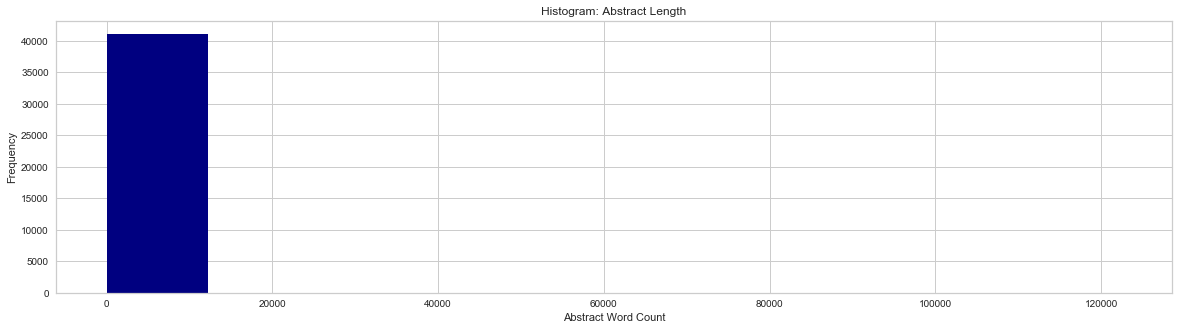

In [10]:
doc_length = docs_length.plot(kind = 'hist', title = 'Histogram: Abstract Length', colormap='jet', figsize =(20,5))
doc_length.set_xlabel("Abstract Word Count")
doc_length.set_ylabel("Frequency")

In [11]:
z_scores = np.abs(stats.zscore(docs_length))
filtered_entries = (z_scores <= 4)
outliers = (z_scores > 4)
outliers_text = text[outliers]
docs_length = docs_length[filtered_entries]

Text(0, 0.5, 'Frequency')

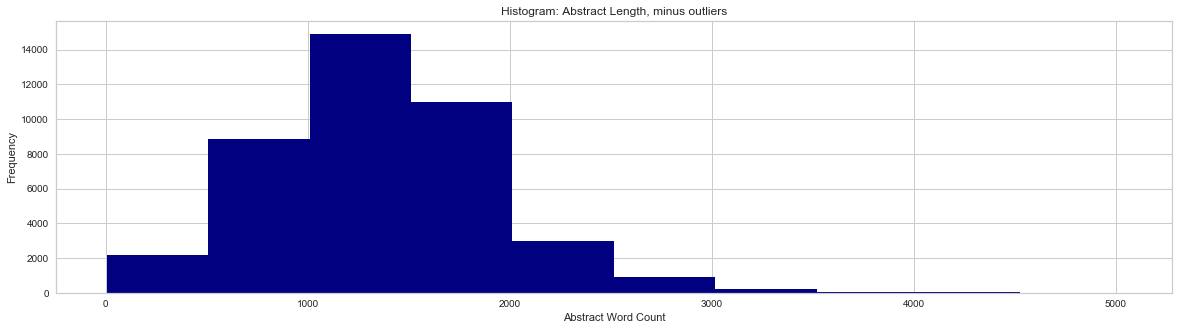

In [12]:
doc_length = docs_length.plot(kind = 'hist', title = 'Histogram: Abstract Length, minus outliers', colormap='jet', figsize =(20,5))
doc_length.set_xlabel("Abstract Word Count")
doc_length.set_ylabel("Frequency")

In [13]:
text = text[filtered_entries]
print(len(text))

41099


# Lemmatization/Stop word Reduction

In [14]:
nlp = spacy.load('en_core_web_lg', disable=['tagger','parser','ner'])

In [15]:
def tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or len(word)==1)]

# Vectorize

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
vec = CountVectorizer(tokenizer = tokenizer, max_df=0.80, min_df=3)

In [19]:
cv = vec.fit_transform(text['abstract'])

# Latent Dirichlet Allocation

In [20]:
from sklearn.decomposition import LatentDirichletAllocation

In [21]:
n_components = 20
lda = LatentDirichletAllocation(n_components=n_components,random_state=42)

In [22]:
lda_doc_dist = lda.fit_transform(cv)

In [23]:
def plot_doc(doc):
    index, value = zip(*[(index, val) for index, val in enumerate(lda_doc_dist[doc])])
    doc_topic_plot = pd.Series(value, index)
    return doc_topic_plot

Text(0, 0.5, 'Topic Proportion')

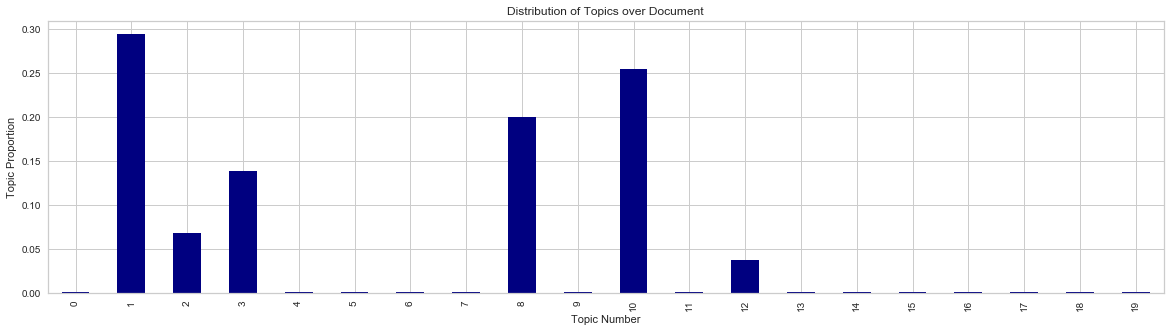

In [24]:
doc = 42
topic_dist_chart = plot_doc(doc).plot(kind = 'bar', title = 'Distribution of Topics over Document', colormap='jet', figsize =(20,5))
topic_dist_chart.set_xlabel("Topic Number")
topic_dist_chart.set_ylabel("Topic Proportion")

In [25]:
text['topic_dist'] = lda_doc_dist.tolist()

C:\Users\brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,cord_uid,title,abstract,publish_time,authors,url,topic_dist
0,xqhn0vbp,Airborne rhinovirus detection and effect of ul...,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,"[0.39634522217658597, 0.0003355704758036747, 0..."
1,gi6uaa83,Discovering human history from stomach bacteria,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,"[0.0013888889108345558, 0.0013888888952914304,..."
2,le0ogx1s,A new recruit for the army of the men of death,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,"[0.0033333333447973647, 0.40422601395140056, 0..."
3,fy4w7xz8,Association of HLA class I with severe acute r...,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,"[0.0002358490601119993, 0.34822513557908713, 0..."
4,0qaoam29,A double epidemic model for the SARS propagation,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,"[0.0003378378510916753, 0.23599478570399626, 0..."


In [58]:
def similar_text(text_to_compare, n_articles = 10):
    store_vals = list()
    topic_dist = text.loc[text_to_compare, 'topic_dist']
    for i in range(len(text)):
        if(i in text.index):
            store_vals.append(sqrt(mean_squared_error(topic_dist, text.loc[i, 'topic_dist'])))
    most_similar = sorted(store_vals)
    return most_similar[1:n_articles + 1]

In [ ]:
def similar_text(text_to_compare, n_articles = 10):
    store_vals = list()
    topic_dist = text.loc[text_to_compare, 'topic_dist']
    for i in range(len(text)):
        if(i in text.index):
            store_vals.append(sqrt(mean_squared_error(topic_dist, text.loc[i, 'topic_dist'])))
    most_similar = sorted(store_vals)
    return most_similar[1:n_articles + 1]

In [59]:
from datetime import datetime
start=datetime.now()

#Statements
similar_text_2(1)

print(datetime.now()-start)

0:00:10.176217


to find for text no in dataset


In [ ]:
new_text = ''

In [ ]:
#new_vec = vec.fit_transform(new_text)

In [ ]:
new_topic_dist = lda.predict_proba(new_vec)

In [265]:
for index,topic in enumerate(lda.components_[:5]):
    print(f'Top 10 words for topic #{index} are:')
    print([vec.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n\n')

Top 10 words for topic #0 are:
['expression', 'function', 'target', 'viral', 'mechanism', 'system', 'host', 'gene', 'review', 'disease']



Top 10 words for topic #1 are:
['effective', 'cancer', 'development', 'therapy', 'cat', 'clinical', 'disease', 'drug', 'treatment', 'vaccine']



Top 10 words for topic #2 are:
['expression', 'host', 'entry', 'fusion', 'infection', 'viral', 'membrane', 'virus', 'cell', 'protein']



Top 10 words for topic #3 are:
['result', 'risk', 'emergency', 'control', 'medical', 'hospital', 'study', 'public', 'care', 'health']



Top 10 words for topic #4 are:
['coronavirus', 'recombinant', 'isolate', 'vaccine', 'ibv', 'gene', 'antibody', 'protein', 'strain', 'virus']





In [266]:
text['topic'] = lda.transform(cv).argmax(axis=1)

In [267]:
def paper_by_topic(topic):
    print("---------There are " + str(len(text[text['topic'] == topic])) + " Articles in this topic cluster.---------")
    return text[text['topic'] == topic]['title']

for i in text['topic'].unique():
    paper_by_topic(i)

---------There are 3466 Articles in this topic cluster.---------
---------There are 1794 Articles in this topic cluster.---------
---------There are 3189 Articles in this topic cluster.---------
---------There are 2511 Articles in this topic cluster.---------
---------There are 3279 Articles in this topic cluster.---------
---------There are 3174 Articles in this topic cluster.---------
---------There are 2854 Articles in this topic cluster.---------
---------There are 2699 Articles in this topic cluster.---------
---------There are 1981 Articles in this topic cluster.---------
---------There are 2479 Articles in this topic cluster.---------
---------There are 1601 Articles in this topic cluster.---------
---------There are 2331 Articles in this topic cluster.---------
---------There are 578 Articles in this topic cluster.---------
---------There are 771 Articles in this topic cluster.---------
---------There are 2320 Articles in this topic cluster.---------
---------There are 1276 Art

In [268]:
count_by_topic = text['topic'].value_counts()

Text(0, 0.5, 'Papers (Qty)')

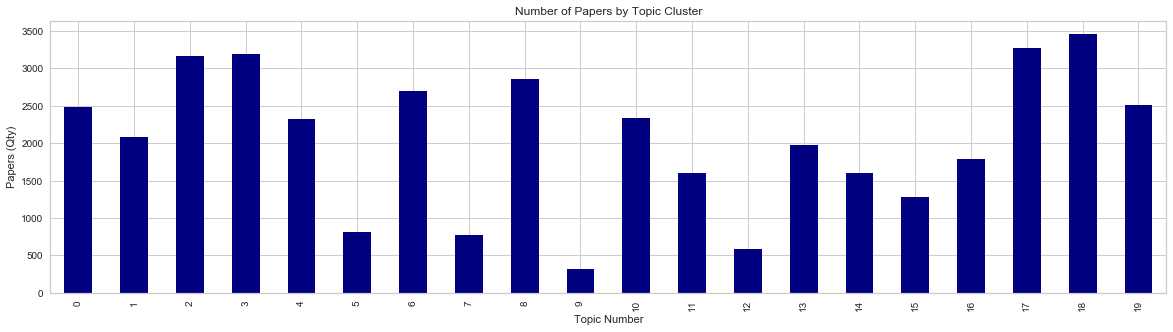

In [269]:
topic_chart = count_by_topic.sort_index().plot(kind = 'bar', title = 'Number of Papers by Topic Cluster', colormap='jet', figsize =(20,5))
topic_chart.set_xlabel("Topic Number")
topic_chart.set_ylabel("Papers (Qty)")

# Visualizations

In [408]:
#tsne = TSNEVisualizer()

In [410]:
#tsne.fit(cv, text['topic'])